# Load dataset

In [1]:
# Download & unzip the dataset, unless it's already present
from pathlib import Path

url = 'https://www.vs.inf.ethz.ch/edu/HS2019/SE/xXjxkLul5TDrlSbniZFaIUu1gKUjZ2qj/example_data.zip'

if not Path("./example_data").is_dir():
  if not Path("./example_data.zip").is_file():
    !pip install wget
    import wget
    wget.download(url,'./example_data.zip')
  from zipfile import ZipFile
  ZipFile('example_data.zip','r').extractall()
print('Data ready')

Data ready


In [2]:
# Read data into Python

# Pandas is a popular library for managing and analysing data in Python.
# Google's course on Machine Learning has a short intro:
# See https://colab.research.google.com/notebooks/mlcc/intro_to_pandas.ipynb
import pandas as pd

directory = 'example_data'

legs_df = pd.read_csv(directory + '/legs.csv', index_col=0)
acc_readings = pd.read_csv(directory + '/acc_readings.csv', index_col=0)
locations_scans = pd.read_csv(directory + '/locations_scans.csv', index_col=0)
bluetooth_scans = pd.read_csv(directory + '/bluetooth_scans.csv', index_col=0)
wifi_scans = pd.read_csv(directory + '/wifi_scans.csv', index_col=0)
gyro_readings = pd.read_csv(directory + '/gyro_readings.csv', index_col=0)
magn_readings = pd.read_csv(directory + '/magn_readings.csv', index_col=0)



# Print the first row of each file (quick sanity check)
print(legs_df.head(1))
print(acc_readings.head(1))
print(locations_scans.head(1))

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


            end    id   mode         start  \
0  1.558109e+12  88.0  605.0  1.558108e+12   

                                   user  
0  408483c0-4287-456d-a35c-b14e28ce10ec  
   acc  leg       reading                                  user        x  \
0    3   88  1.558108e+12  408483c0-4287-456d-a35c-b14e28ce10ec  0.00639   

          y         z  
0  0.030259  0.008629  
   acc         alt  bearing        lat  leg       lng       reading  speed  \
0  3.0  492.416046        0  47.324327   88  8.530802  1.558108e+12    0.0   

                                   user  
0  408483c0-4287-456d-a35c-b14e28ce10ec  





# Calculate windows and features

In [3]:
# Split data into windows for further processing

# NumPy is a popular library for fast numerical computations with large arrays and matrices.
# At https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/02.00-Introduction-to-NumPy.ipynb
# you can find an introduction to NumPy (Click on "Understanding Data Types in Python >" for the next page)
import numpy as np

#window size in ms
window_size = 6000

# dataframe containing the features.
# Columns: mean acceleration, max speed, transportation mode (target variable)
features_df = pd.DataFrame()

# iterate over all legs
for index, row in legs_df.iterrows():
    print('windowing', row['user'], row['id'])
    boundary_left = row['start']
    boundary_right = boundary_left + window_size
    previous_bluetooth = 0
    previous_wifi = 0
    
    current_leg_df_acc = acc_readings.loc[
                (acc_readings['user'] == row['user']) &
                (acc_readings['leg'] == row['id'])
            ].copy()
    
    current_leg_df_gyro = gyro_readings.loc[
                (gyro_readings['user'] == row['user']) &
                (gyro_readings['leg'] == row['id'])
            ].copy()
    
    current_leg_df_magn = magn_readings.loc[
                (magn_readings['user'] == row['user']) &
                (magn_readings['leg'] == row['id'])
            ].copy()
    
    current_leg_df_loc = locations_scans.loc[
                (locations_scans['user'] == row['user']) &
                (locations_scans['leg'] == row['id'])
            ].copy()
    
    while boundary_right < row['end']:
        features = {}
        
        
        # Accelerometer Data  
        acc_readings_in_window = current_leg_df_acc.loc[
            (current_leg_df_acc['reading'] > boundary_left) &
            (current_leg_df_acc['reading'] <= boundary_right)
        ].copy()
        # calculate magnitude
        acc_readings_in_window['magnitude'] = np.linalg.norm(acc_readings_in_window[['x','y','z']].values,axis=1)
        # save mean magnitude as feature
        features['acc_mean'] = acc_readings_in_window['magnitude'].mean()
        features['acc_x'] = acc_readings_in_window['x'].mean()
        features['acc_y'] = acc_readings_in_window['y'].mean()
        features['acc_z'] = acc_readings_in_window['z'].mean()
        
        # Location Data
        loc_readings_in_window = current_leg_df_loc.loc[
            (current_leg_df_loc['reading'] > boundary_left) &
            (current_leg_df_loc['reading'] <= boundary_right)
        ].copy()
        # save mean magnitude as feature
        features['min_speed'] = loc_readings_in_window['speed'].min()
        features['max_speed'] = loc_readings_in_window['speed'].max()
        features['avg_speed'] = loc_readings_in_window['speed'].mean()
        features['accuracy_gps'] = loc_readings_in_window['acc'].mean()
    
        # Bluetooth Data
        bluetooth_scans_in_window = bluetooth_scans.loc[
                (bluetooth_scans['leg'] == row['id']) &
                (bluetooth_scans['user'] == row['user']) &
                (bluetooth_scans['reading_time'] > boundary_left) &
                (bluetooth_scans['reading_time'] <= boundary_right)
            ].copy()
        # Unique Bluetooth devices
        if (len(bluetooth_scans_in_window.mac) == 0): 
            if (bluetooth_scans_in_window['mac'].nunique() != 0):
                features['bluetooth_numbers'] = bluetooth_scans_in_window['mac'].nunique()
                previous_bluetooth = bluetooth_scans_in_window['mac'].nunique()
            else:
                features['bluetooth_numbers'] = previous_bluetooth 
        else:
            features['bluetooth_numbers'] = bluetooth_scans_in_window['mac'].nunique()
            previous_bluetooth = bluetooth_scans_in_window['mac'].nunique()
            
        
        # WIFI
        '''wifi_scans_in_window = wifi_scans.loc[
                (wifi_scans['leg'] == row['id']) &
                (wifi_scans['user'] == row['user']) &
                (wifi_scans['reading_time'] > boundary_left) &
                (wifi_scans['reading_time'] <= boundary_right)
            ].copy()
        
        if (len(wifi_scans_in_window.bssid) == 0):   
            print("EMPTY")
            if (wifi_scans_in_window['bssid'].nunique() != 0):
                features['wifi_numbers'] = wifi_scans_in_window['bssid'].nunique()
                previous_wifi = wifi_scans_in_window['bssid'].nunique()
                print(wifi_scans_in_window['bssid'].nunique())
            else:
                features['wifi_numbers'] = previous_wifi  
                print(previous_wifi)
        else:
            print("NOT EMPTY")
            features['wifi_numbers'] = wifi_scans_in_window['bssid'].nunique()
            previous_wifi = wifi_scans_in_window['bssid'].nunique()
            print(wifi_scans_in_window['bssid'].nunique())'''             
        
        #Get Gyro
        gyro_readings_in_window = current_leg_df_gyro.loc[
            (current_leg_df_gyro['reading'] > boundary_left) &
            (current_leg_df_gyro['reading'] <= boundary_right)
        ].copy()
        # calculate magnitude
        gyro_readings_in_window['magnitude'] = np.linalg.norm(gyro_readings_in_window[['x','y','z']].values,axis=1) 
        # save mean magnitude as feature
        features['gyro_mean'] = gyro_readings_in_window['magnitude'].mean()
        features['gyro_x'] = gyro_readings_in_window['x'].mean()
        features['gyro_y'] = gyro_readings_in_window['y'].mean()
        features['gyro_z'] = gyro_readings_in_window['z'].mean()
        
        #Magnetic Field Data
        magn_readings_in_window = current_leg_df_magn.loc[
            (current_leg_df_magn['reading'] > boundary_left) &
            (current_leg_df_magn['reading'] <= boundary_right)
        ].copy()
        # calculate magnitude
        magn_readings_in_window['magnitude'] = np.linalg.norm(magn_readings_in_window[['x','y','z']].values,axis=1) 
        # save mean magnitude as feature
        features['magn_mean'] = magn_readings_in_window['magnitude'].mean()
        features['magn_x'] = magn_readings_in_window['x'].mean()
        features['magn_y'] = magn_readings_in_window['y'].mean()
        features['magn_z'] = magn_readings_in_window['z'].mean()
        
        
        # save user, leg and transportation mode
        features['user'] = row['user']
        features['leg'] = row['id']
        features['mode'] = row['mode']
        
        # save features in features data frame
        features_df = features_df.append(features, ignore_index=True)
        
        # set new boundaries
        boundary_left = boundary_right
        boundary_right = boundary_left + window_size
        
print('Feature calculation done')
print(features_df.head())

#features_df.to_csv("window_features.csv")
#features_df.to_excel("Results/testn.xlsx")


windowing 408483c0-4287-456d-a35c-b14e28ce10ec 88.0
windowing 408483c0-4287-456d-a35c-b14e28ce10ec 89.0
windowing 408483c0-4287-456d-a35c-b14e28ce10ec 90.0
windowing 408483c0-4287-456d-a35c-b14e28ce10ec 91.0
windowing 408483c0-4287-456d-a35c-b14e28ce10ec 92.0
windowing 408483c0-4287-456d-a35c-b14e28ce10ec 93.0
windowing 408483c0-4287-456d-a35c-b14e28ce10ec 94.0
windowing 408483c0-4287-456d-a35c-b14e28ce10ec 95.0
windowing 408483c0-4287-456d-a35c-b14e28ce10ec 96.0
windowing 408483c0-4287-456d-a35c-b14e28ce10ec 97.0
windowing 408483c0-4287-456d-a35c-b14e28ce10ec 98.0
windowing 408483c0-4287-456d-a35c-b14e28ce10ec 99.0
windowing 408483c0-4287-456d-a35c-b14e28ce10ec 100.0
windowing 408483c0-4287-456d-a35c-b14e28ce10ec 101.0
windowing 408483c0-4287-456d-a35c-b14e28ce10ec 102.0
windowing 408483c0-4287-456d-a35c-b14e28ce10ec 103.0
windowing 408483c0-4287-456d-a35c-b14e28ce10ec 104.0
windowing 408483c0-4287-456d-a35c-b14e28ce10ec 105.0
windowing 408483c0-4287-456d-a35c-b14e28ce10ec 106.0
windo

windowing fa7ab975-bd41-4c5a-82bb-1c5dd89c5a9f 35.0
windowing fa7ab975-bd41-4c5a-82bb-1c5dd89c5a9f 36.0
windowing fa7ab975-bd41-4c5a-82bb-1c5dd89c5a9f 37.0
windowing fa7ab975-bd41-4c5a-82bb-1c5dd89c5a9f 47.0
windowing fa7ab975-bd41-4c5a-82bb-1c5dd89c5a9f 51.0
windowing fa7ab975-bd41-4c5a-82bb-1c5dd89c5a9f 52.0
windowing fa7ab975-bd41-4c5a-82bb-1c5dd89c5a9f 53.0
windowing fa7ab975-bd41-4c5a-82bb-1c5dd89c5a9f 54.0
windowing fa7ab975-bd41-4c5a-82bb-1c5dd89c5a9f 55.0
windowing fa7ab975-bd41-4c5a-82bb-1c5dd89c5a9f 56.0
windowing fa7ab975-bd41-4c5a-82bb-1c5dd89c5a9f 60.0
windowing fa7ab975-bd41-4c5a-82bb-1c5dd89c5a9f 61.0
windowing fa7ab975-bd41-4c5a-82bb-1c5dd89c5a9f 62.0
windowing fa7ab975-bd41-4c5a-82bb-1c5dd89c5a9f 64.0
windowing fa7ab975-bd41-4c5a-82bb-1c5dd89c5a9f 65.0
windowing fa7ab975-bd41-4c5a-82bb-1c5dd89c5a9f 66.0
windowing fa7ab975-bd41-4c5a-82bb-1c5dd89c5a9f 67.0
windowing fa7ab975-bd41-4c5a-82bb-1c5dd89c5a9f 68.0
windowing fa7ab975-bd41-4c5a-82bb-1c5dd89c5a9f 69.0
windowing fa

FileCreateError: [Errno 2] No such file or directory: 'Results/testn.xlsx'

In [6]:
features_df.to_pickle("./feature_dfnew6stom.pkl")

# Shuffle split data into training and test set

In [7]:
# Randomly split data into training and test set

# Scikit-Learn is a popular library for common machine learning algorithms.
# Here, it is used only for its support for efficiently splitting a dataset.
# For more information, see https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.02-Introducing-Scikit-Learn.ipynb
from sklearn.model_selection import StratifiedShuffleSplit

y = np.array(features_df['mode'])
X = np.array(features_df.drop(['user', 'leg', 'mode'], axis=1))
X = np.nan_to_num(X)

shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

train_indices, test_indices = next(shuffle_split.split(X=X, y=y))

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

print('Shape of X_train', X_train.shape)
print('Shape of y_train', y_train.shape)
print('Shape of X_test', X_test.shape)
print('Shape of y_test', y_test.shape)

Shape of X_train (15252, 17)
Shape of y_train (15252,)
Shape of X_test (6537, 17)
Shape of y_test (6537,)


# Train XGBoost on training set

In [11]:
# Train Gradient Boosted Decisions Trees

#XGBoost implements the"Extreme Gradient Boosting" algorithm.
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(n_jobs=-1, objective='multi:softprob', random_state=42, n_estimators = 500, learning_rate = 0.25)

xgb_classifier.fit(X_train, y_train)

print('Training done')

Training done


# Make classifications on testing set

In [12]:
y_pred = xgb_classifier.predict(X_test)

print('Shape of y_pred', y_pred.shape)

Shape of y_pred (6537,)


# Print classification reports

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=4))

# confusion matrix
confMatrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print(confMatrix)

              precision    recall  f1-score   support

         2.0     0.9400    0.9648    0.9522      2242
         3.0     0.9226    0.9051    0.9137       316
         4.0     0.9236    0.7436    0.8239       195
         5.0     0.9776    0.9656    0.9716       407
       304.0     0.9071    0.9363    0.9215      1272
       601.0     0.9276    0.8981    0.9126      1070
       602.0     0.8548    0.4953    0.6272       107
       605.0     0.9561    0.9849    0.9703       928

    accuracy                         0.9341      6537
   macro avg     0.9262    0.8617    0.8866      6537
weighted avg     0.9335    0.9341    0.9325      6537

Predicted  2.0    3.0    4.0    5.0    304.0  601.0  602.0  605.0
Actual                                                           
2.0         2163      5      1      2     47     23      1      0
3.0            9    286      0      0     19      2      0      0
4.0            9      0    145      4     27      9      1      0
5.0            5   

# Train model on whole set and export it

In [8]:
xgb_classifier.fit(X, y)
print('xgboost.model')
xgb_classifier.save_model('xgboost_model_test')
print('model exported')

xgboost.model
model exported


In [9]:
'''import pandas as pd
import openpyxl

df = pd.read_csv('window.csv', index_col=False)
df.to_excel("Results/acc_mean.xlsx")

df.loc[df['mode'] == 2.0]
print(df.head())
df_acc_mean = df[['acc_mean', 'mode']]
df_acc_mean.loc[df_acc_mean['mode'] == '2.0']
df_acc_mean.dropna(axis=1)

print(df_acc_mean['acc_mean'].mean())


#df.loc[df['acc_mean'] == some_value]'''


'import pandas as pd\nimport openpyxl\n\ndf = pd.read_csv(\'window.csv\', index_col=False)\ndf.to_excel("Results/acc_mean.xlsx")\n\ndf.loc[df[\'mode\'] == 2.0]\nprint(df.head())\ndf_acc_mean = df[[\'acc_mean\', \'mode\']]\ndf_acc_mean.loc[df_acc_mean[\'mode\'] == \'2.0\']\ndf_acc_mean.dropna(axis=1)\n\nprint(df_acc_mean[\'acc_mean\'].mean())\n\n\n#df.loc[df[\'acc_mean\'] == some_value]'

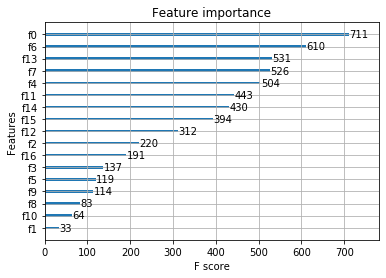

In [26]:
#feature importance 

from xgboost import plot_importance
from matplotlib import pyplot

# fit model no training data
model = XGBClassifier()
model.fit(X, y)
# plot feature importance
plot_importance(model)
pyplot.show()

In [17]:
# fit model on all training data
# check it out

model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    
#source: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

Accuracy: 87.87%
Thresh=0.005, n=17, Accuracy: 87.87%
Thresh=0.008, n=16, Accuracy: 87.87%
Thresh=0.011, n=15, Accuracy: 87.90%
Thresh=0.020, n=14, Accuracy: 88.02%
Thresh=0.023, n=13, Accuracy: 87.84%
Thresh=0.023, n=12, Accuracy: 87.95%
Thresh=0.033, n=11, Accuracy: 87.73%
Thresh=0.037, n=10, Accuracy: 87.09%
Thresh=0.042, n=9, Accuracy: 87.09%
Thresh=0.045, n=8, Accuracy: 85.79%
Thresh=0.050, n=7, Accuracy: 83.13%
Thresh=0.056, n=6, Accuracy: 80.88%
Thresh=0.085, n=5, Accuracy: 77.93%
Thresh=0.099, n=4, Accuracy: 77.59%
Thresh=0.114, n=3, Accuracy: 71.81%
Thresh=0.165, n=2, Accuracy: 56.19%
Thresh=0.184, n=1, Accuracy: 54.11%


In [ ]:
# grid search for Hyperparameter tuning 
import pyplot
import numpy as np
model = XGBClassifier()
n_estimators = [200, 350, 500, 650, 800, 1000]
learning_rate = [0.001 , 0.01, 0.1, 0.2]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    pyplot.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators_vs_learning_rate.png')